In [1]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
import pandas as pd
%pylab inline
from pylab import rcParams
rcParams['figure.figsize'] = 16,4

Populating the interactive namespace from numpy and matplotlib


### Load a time series with dates, and do some Pandas magics to group it into a matrix

/usr/local/lib/python2.7/dist-packages/pandas/core/series.py:2890: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  


Rows = day of the month (first 28)
Columns = months (12 * 10 years)


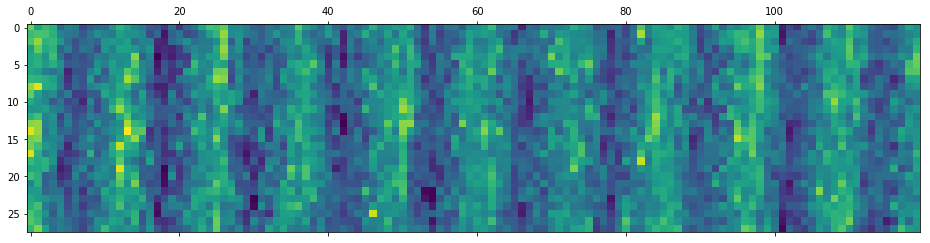

In [2]:
series = pd.Series.from_csv('daily-minimum-temperatures-in-me.csv', header=0)

from pandas import TimeGrouper
from pandas import DataFrame
# Group by month, i.e. we have an entry for each year-month pair
groups = series.groupby(TimeGrouper('M'))
mm = DataFrame()
for name, group in groups:
    # take only first 28 days, to avoid empty cells for short months
    mm["%s-%s" % (name.year,name.month)] = group.values[0:28]
    # Alternative: fill shorter months with 0 till 31st day
    # mm["%s-%s" % (name.year,name.month)] = numpy.pad(group.values,(0,31-len(group)),'constant')

matshow(mm, interpolation=None, aspect='auto')
print "Rows = day of the month (first 28)"
print "Columns = months (12 * 10 years)"

### Dataset too large for us! Take only the first 48 months (4 years)

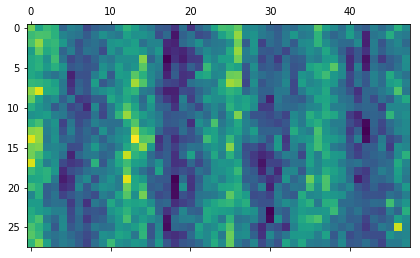

In [3]:
mm_small = mm.T[:48].T
matshow(mm_small, interpolation=None, aspect='auto')

## DTW definition

In [4]:
def dtw(x, y, dist):
    """
    Computes Dynamic Time Warping (DTW) of two sequences.

    :param array x: N1*M array
    :param array y: N2*M array
    :param func dist: distance used as cost measure

    Returns the minimum distance, the cost matrix, the accumulated cost matrix, and the wrap path.
    """
    assert len(x)
    assert len(y)
    r, c = len(x), len(y)
    
    # D0 = D1 = matrix of point-to-point costs
    D0 = zeros((r + 1, c + 1))
    D0[0, 1:] = inf
    D0[1:, 0] = inf
    D1 = D0[1:, 1:] # view (hide first column and first row)
    
    # Fill the point-to-point costs matrix
    for i in range(r):
        for j in range(c):
            D1[i, j] = dist(x[i], y[j])
            
    # C = matrix of optimal paths costs
    C = D1.copy()
    for i in range(r):
        for j in range(c):
            D1[i, j] += min(D0[i, j], D0[i, j+1], D0[i+1, j])
    
    # Infer the path from matrix C
    if len(x)==1:
        path = zeros(len(y)), range(len(y))  # special case 1
    elif len(y) == 1:
        path = range(len(x)), zeros(len(x))  # special case 2
    else:
        path = _traceback(D0)  # general case
        
    return D1[-1, -1], C, D1, path

# Function for inferring the optima path (general case)
# Starts from last cell and goes backward...
def _traceback(D):
    i, j = array(D.shape) - 2
    p, q = [i], [j]
    while ((i > 0) or (j > 0)):
        tb = argmin((D[i, j], D[i, j+1], D[i+1, j]))
        if (tb == 0):
            i -= 1
            j -= 1
        elif (tb == 1):
            i -= 1
        else: # (tb == 2):
            j -= 1
        p.insert(0, i)
        q.insert(0, j)
    return array(p), array(q)

In [5]:
def distance(x,y):
    return abs(x-y)

### Compute matrix "dd2" of distances among the 48 time series in the dataset (48 months)

In [6]:
%%time
# CAUTION !!! CAN BE VERY SLOW !!!
month_list = mm_small.keys()
# Compute upper half of matrix
dd1 = [ [ (dtw(mm_small[month_list[x]],mm_small[month_list[y]],distance)[0] \
           if y > x else -1)  \
         for y in range(len(month_list)) ] 
       for x in range(len(month_list)) ]
# Copy values also to the lower half, exployting symmetry of the distance function
dd2 = [ [ (dd1[x][y] if y > x else dd1[y][x])  for y in range(len(month_list)) ] for x in range(len(month_list)) ]
# Finally, the diagonal
for i in range(len(month_list)):
    dd2[i][i] = 0.0

CPU times: user 25.4 s, sys: 31.7 ms, total: 25.4 s
Wall time: 25.4 s


### Plot the matrix of distances
One cell represents the distance between corresponding time series (one per month). As we can expect, months of the same season in different years are very similar (blue color).

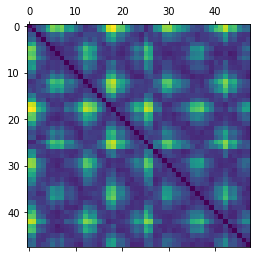

In [7]:
matshow(dd2, interpolation=None, aspect='auto')

# Clustering with DBSCAN using a pre-computed distance matrix (dd2)
Very easy to do. Yet, you need to find a good value for the "eps" parameter...

In [8]:
from scipy.stats import itemfreq

db = DBSCAN(eps=46, min_samples=2, metric='precomputed').fit(dd2)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)

print('Number of clusters found: %d' % n_clusters_)
print itemfreq(db.labels_)

cluster_sets = [ (l_,month_list[db.labels_ == l_]) for l_ in set(db.labels_) ]
for pp in cluster_sets:
    print pp[0], "\t--> ", list(pp[1])

Number of clusters found: 3
[[-1  9]
 [ 0  3]
 [ 1 21]
 [ 2 15]]
0 	-->  ['1981-1', '1981-2', '1983-2']
1 	-->  ['1981-3', '1981-9', '1981-10', '1981-11', '1981-12', '1982-1', '1982-2', '1982-10', '1982-11', '1982-12', '1983-1', '1983-4', '1983-5', '1983-10', '1983-11', '1983-12', '1984-1', '1984-2', '1984-3', '1984-4', '1984-12']
2 	-->  ['1981-6', '1981-7', '1981-8', '1982-6', '1982-7', '1982-8', '1982-9', '1983-6', '1983-7', '1983-8', '1984-5', '1984-6', '1984-7', '1984-8', '1984-9']
-1 	-->  ['1981-4', '1981-5', '1982-3', '1982-4', '1982-5', '1983-3', '1983-9', '1984-10', '1984-11']


### Plot the distribution of distances to understand what range of values for eps could make sense

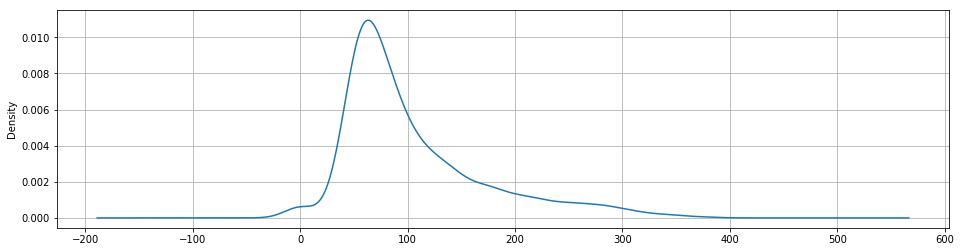

In [9]:
from pandas import Series
Series(reshape(dd2,(1,48*48))[0]).plot(kind='kde')
pyplot.grid(True)
#plot(sort(reshape(dd2,(1,48*48))[0]))
#plot([0,2400],[45,45],'r--')

### Second try: run the clustering with several different values of eps and plot the results (number of clusters and size of noise) to choose a good threshold to use above.

Text(0.5,1,'N. clusters (green) and noise size (blue) vs. eps')

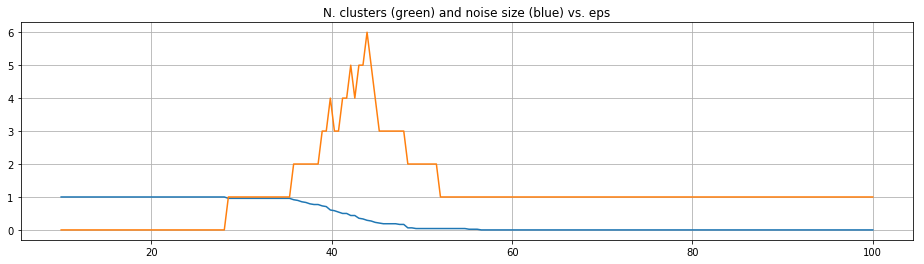

In [10]:
eps_list = linspace(10.0,100.0,num=200)
#eps_list = linspace(0.78,0.8,num=200)
noise_list = array([])
n_clusters_list = array([])
for myeps in eps_list:
    db = DBSCAN(myeps, min_samples=2, metric='precomputed').fit(dd2)
    noise_list = append(noise_list, sum([ 1 if i==-1 else 0 for i in db.labels_]))
    n_clusters_list = append(n_clusters_list, len(set(db.labels_)) - (1 if -1 in db.labels_ else 0))
plot(eps_list, noise_list/48)
plot(eps_list, n_clusters_list)
pyplot.grid(True)
pyplot.title("N. clusters (green) and noise size (blue) vs. eps")
#plot([0.8,0.8],[0,5],'r-')

# Visualizing clusters

### Method 1: Multi-Dimensional Scaling
Translates each object (time series) into a 2-D point. Based on heuristics that tries to respect the distances between the original objects.

Stress value:  290056.3115299827


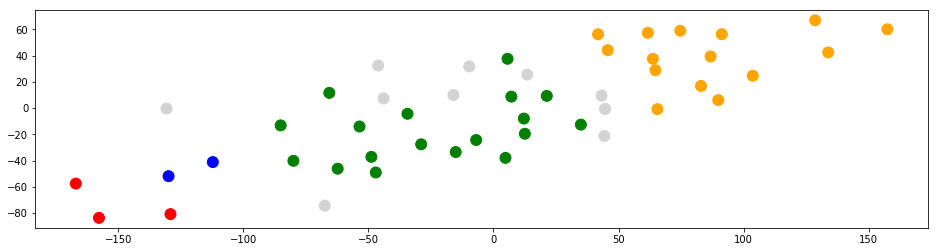

In [11]:
from sklearn import manifold
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(dd2)
print "Stress value: ", pos.stress_

# Assign colors based on clusters
db = DBSCAN(eps=45.00, min_samples=2, metric='precomputed').fit(dd2)
cols = ['lightgray', 'red', 'green', 'orange', 'blue']
cc = [ cols[l+1] for l in db.labels_]
scatter(pos.embedding_.T[0], pos.embedding_.T[1], color=cc, s=120)

### Method 2: plot time series with colors

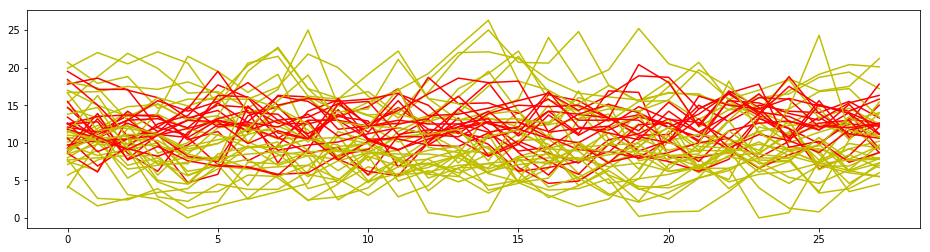

In [12]:
for i in range(len(db.labels_)):
    plot(mm_small[month_list[i]],'r-' if db.labels_[i]==1 else 'y-')

### Method 3: heatmaps, sorting the rows based on clusters
Hopefully, data in adjacent rows look similar than the others

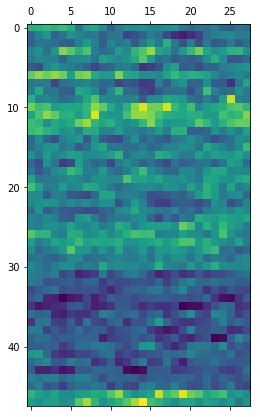

In [13]:
from operator import itemgetter
mm_sort=sorted(zip(array(mm_small.T),db.labels_),key=itemgetter(1))
mm_sort2=[el[0] for el in mm_sort]
matshow(mm_sort2, interpolation=None, aspect='auto')

#### As above, comparing against original data ordering

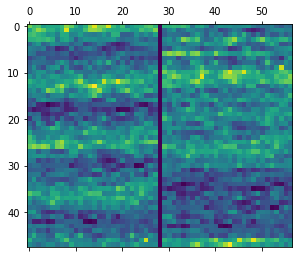

In [14]:
before = mm_small.T
after = mm_sort2
separator = array([[ 0 ] * 48]).T
matshow(hstack((before, separator, after)), interpolation=None, aspect='auto')

# Using Euclidean distance
Simply adopt the following function instead of our dtw. Just take care of putting the list of numbers inside a double square parenthesis: [[ 1,2,3 ]] and not [ 1,2,3 ].

In [15]:
from sklearn.metrics.pairwise import euclidean_distances
euclidean_distances([[0,6,1]], [[1,5,7]])

array([[6.164414]])